# Travelling salesman problem
### Group 3
Angel URIOT
Arthur AZAMBRE

### Imports

In [15]:
import cplex
import numpy as np
import matplotlib.pyplot as plt

### Settings

In [16]:
NB_CITIES = 30
STOCHASTIQUE = True

### Cities

In [17]:
cities = np.random.uniform(0., 1., (NB_CITIES, 2))

In [18]:
def plot(cities, path = None):

	cities = np.array(cities)

	# Plot the paths
	if path is None:
		for i in range(NB_CITIES - 1):
			plt.plot(cities[[i, i + 1], 0], cities[[i, i + 1], 1], color = 'red')

	else:
		path = np.array(path)
		for p in path:
			plt.plot(p[:, 0], p[:, 1], color = 'red')

	# Plot the cities
	plt.plot(cities[:, 0], cities[:, 1], 'o', color = 'black')

	# Axis
	plt.xlim(-0.01, 1.01)
	plt.ylim(-0.01, 1.01)
	plt.gca().set_aspect('equal', adjustable = 'box')
	plt.axis('off')

	# Show
	plt.show()

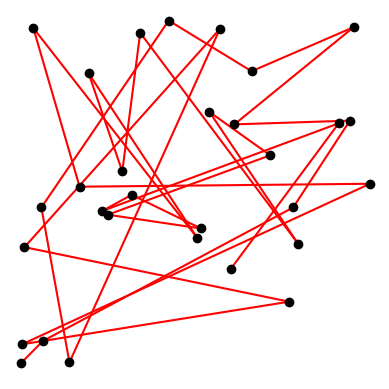

In [19]:
plot(cities)

### Model

Create the variables

In [20]:
# The cost of each arc
cost = []

for i in range(NB_CITIES):
	cost.append([])
	for j in range(NB_CITIES):
		cost[i].append(np.linalg.norm(cities[i] - cities[j]))

cost = np.array(cost)

Create the model

In [21]:
model = cplex.Cplex()

Objective function

In [22]:
model.objective.set_sense(model.objective.sense.minimize)

Variables

In [23]:
model.variables.add(
	names = ["x_" + str(i) + "_" + str(j) for j in range(NB_CITIES) for i in range(NB_CITIES)],
	obj = [cost[i][j] for j in range(NB_CITIES) for i in range(NB_CITIES)],
	lb = [0] * (NB_CITIES ** 2),
	ub = [1] * (NB_CITIES ** 2),
	types = ["B"] * (NB_CITIES ** 2)
)

model.variables.add(
	names = ["u_" + str(i) for i in range(NB_CITIES)],
	obj = [0] * NB_CITIES,
	lb = [0] * NB_CITIES,
	ub = [cplex.infinity] * NB_CITIES,
	types = ["C"] * NB_CITIES
)

range(900, 930)

Constraints

In [24]:
# 1a
for i in range(NB_CITIES):

	temp = []

	for j in range(NB_CITIES):
		if i != j:
			temp.append("x_" + str(i) + "_" + str(j))

	model.linear_constraints.add(lin_expr = [[temp, [1] * len(temp)]], senses = ["E"], rhs = [1])

In [25]:
# 1b
for j in range(NB_CITIES):

	temp = []

	for i in range(NB_CITIES):
		if i != j:
			temp.append("x_" + str(i) + "_" + str(j))

	model.linear_constraints.add(lin_expr = [[temp, [1] * len(temp)]], senses = ["E"], rhs = [1])

In [26]:
# 1c
# ui + xij <= uj + (NB_CITIES - 1) * (1 - xij) <=> ui - uj + NB_CITIES * xij <= NB_CITIES - 1
# 2 <= j <= NB_CITIES

for i in range(NB_CITIES):
	for j in range(1, NB_CITIES):
		if i != j:
			model.linear_constraints.add(
				lin_expr = [[["u_" + str(i), "u_" + str(j), "x_" + str(i) + "_" + str(j)], [1, -1, NB_CITIES]]],
				senses = ["L"],
				rhs = [NB_CITIES - 1]
			)
		else:
			model.linear_constraints.add(
				lin_expr = [[["x_" + str(i) + "_" + str(j)], [NB_CITIES]]],
				senses = ["L"],
				rhs = [NB_CITIES - 1]
			)

In [ ]:
# 1d

s = 1.96

for i in range(NB_CITIES):
	if i != j:
		model.linear_constraints.add(
			lin_expr = [[[], []]],
			senses = [],
			rhs = []
		)

Solve

In [27]:
model.solve()

Version identifier: 22.1.0.0 | 2022-03-25 | 54982fbec
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIP Presolve eliminated 29 rows and 31 columns.
MIP Presolve modified 58 coefficients.
Reduced MIP has 901 rows, 899 columns, and 4234 nonzeros.
Reduced MIP has 870 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.25 ticks)
Probing time = 0.00 sec. (2.56 ticks)
Cover probing fixed 0 vars, tightened 29 bounds.
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 29 rows and 0 columns.
Reduced MIP has 872 rows, 899 columns, and 4176 nonzeros.
Reduced MIP has 870 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.88 ticks)
Probing time = 0.00 sec. (2.56 ticks)
Clique table members: 466.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 16 threads.
Root relaxation solution time = 0.00 sec. (1.39 ticks)

        No

Results


Objective value = 4.75188281873206


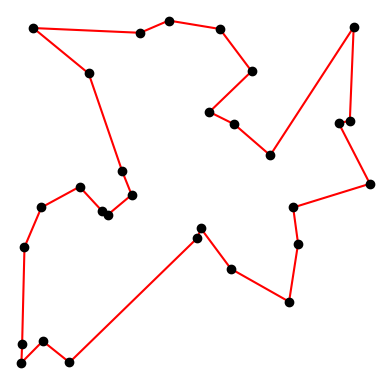

In [28]:
result = model.solution.get_values()

print("\nObjective value =", model.solution.get_objective_value())

paths = []

for i in range(NB_CITIES):
	for j in range(NB_CITIES):
		if result[i * NB_CITIES + j] == 1:
			paths.append([cities[i], cities[j]])

plot(cities, paths)